In [1]:
%cd ../

/home/hoanghu/projects/Food-Waste-Optimization


In [21]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from darts.models import ARIMA, LinearRegressionModel, RandomForest, XGBModel
from darts import TimeSeries
from statsmodels.tsa.stattools import adfuller, kpss
from darts import metrics

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

In [4]:
path_root_trained_model = Path("trained_models")
path_processed = Path("experiments_hoangle/processed/fact.csv")

# Read dataset

In [5]:
raw = pd.read_csv(path_processed, header=0, parse_dates=[0])

raw.head(5)

,date,restaurant,num_fish,num_chicken,num_vegetable,num_meat,num_NotMapped,num_vegan,num_customer_in,num_customer_out,num_rcpts,amnt_waste_customer,amnt_waste_coffee,amnt_waste_kitchen,amnt_waste_hall
0,2023-01-02,Chemicum,85.0,0.0,0.0,171.0,1.0,91.0,NaN,NaN,272.0,4.70,1.2,12.0,0.0
1,2023-01-03,Chemicum,163.0,0.0,32.0,78.0,1.0,120.0,NaN,NaN,327.0,5.00,1.4,14.8,0.0
2,2023-01-04,Chemicum,70.0,0.0,0.0,218.0,3.0,137.0,NaN,NaN,351.0,4.15,4.0,7.1,0.0
3,2023-01-05,Chemicum,232.0,85.0,0.0,2.0,4.0,178.0,NaN,NaN,437.0,10.00,3.3,8.5,0.0
4,2023-01-06,Chemicum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Start experiments

In [6]:
RESTAURANTS = raw['restaurant'].unique()
WASTE_TYPES = ['amnt_waste_customer', 'amnt_waste_coffee', 'amnt_waste_kitchen', 'amnt_waste_hall']


# This cutoff date is used for all 3 forecasting models of 3 corresponding restaurants
# to ensure the datetime of predicted series among 3 restaurants are the same
DATE_START = '2023-01-09'
DATE_END = '2024-05-08'


# This EPS is added to series to avoid 0s
EPS = 1e-4

# This is used for both training (output_chunk_length) and backtesting/predicting (forecast_horizon)
FORECAST_HORIZON = 5

In [7]:
df_metrics = pd.DataFrame({
    'version': [],
    'metric': [],
    'criterion': [],
    'metric_value': []
})

## version 1.0

Train 4 waste types of each restaurant separatedly

### Create data for backtesting

In [8]:
freq = pd.offsets.BusinessDay()
date_range = pd.date_range(start=DATE_START, end=DATE_END, freq=freq)

for restaurant in RESTAURANTS:
    df_restaurant_raw = raw[raw['restaurant'] == restaurant][['date', 'restaurant', *WASTE_TYPES]]\
        .drop(columns='restaurant')
    df_restaurant_raw = df_restaurant_raw[~df_restaurant_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'df_restaurant_raw'
    df_restaurant = pd.DataFrame({'date': date_range})
    df_restaurant = df_restaurant.merge(df_restaurant_raw, on='date', how='left')

    # Fill nan values by column-wise mean
    fillna_vals = df_restaurant.mean(axis=0)

    for waste_type in WASTE_TYPES:
        df_restaurant.fillna({waste_type: fillna_vals[waste_type]}, inplace=True)

    series = TimeSeries.from_dataframe(
        df=df_restaurant,
        time_col='date',
        freq=freq,
        fill_missing_dates=False,
        value_cols=WASTE_TYPES
    )
    series = series + EPS       # Avoid exactly 0 value

    # Define model
    add_encoders = {
        'cyclic': {
            'past': ['dayofweek']
        },
        'datetime_attribute': {'past': ['dayofweek']},
    }
    model = LinearRegressionModel(
        lags=5,
        lags_past_covariates=5,
        add_encoders=add_encoders,
        output_chunk_length=FORECAST_HORIZON
    )

    rmse_bt, mse_bt = model.backtest(
        series,
        forecast_horizon=FORECAST_HORIZON,
        metric=[metrics.rmse, metrics.mse],
        metric_kwargs={'component_reduction': None}
    ).tolist()

    for waste_type, rmse, mse in zip(WASTE_TYPES, rmse_bt, mse_bt):
        waste_type = waste_type.replace('amnt_waste_', '')

        df_metrics.loc[len(df_metrics.index)] = [
            'v1.0',
            'rmse',
            f"{restaurant}_{waste_type}",
            rmse
        ]
        df_metrics.loc[len(df_metrics.index)] = [
            'v1.0',
            'mse',
            f"{restaurant}_{waste_type}",
            mse
        ]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


## version 1.1

Train 4 waste types of 3 restaurants as the same time

### Create data for backtesting

In [9]:
freq = pd.offsets.BusinessDay()
date_range = pd.date_range(start=DATE_START, end=DATE_END, freq=freq)

df = pd.DataFrame({'date': date_range})

for restaurant in RESTAURANTS:
    df_restaurant_raw = raw[raw['restaurant'] == restaurant][['date', 'restaurant', *WASTE_TYPES]]\
        .drop(columns='restaurant')
    df_restaurant_raw = df_restaurant_raw[~df_restaurant_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'df_restaurant_raw'
    df_restaurant = pd.DataFrame({'date': date_range})
    df_restaurant = df_restaurant.merge(df_restaurant_raw, on='date', how='left')

    # Fill nan values by column-wise mean
    fillna_vals = df_restaurant.mean(axis=0)

    for waste_type in WASTE_TYPES:
        df_restaurant.fillna({waste_type: fillna_vals[waste_type]}, inplace=True)

    # rename column
    df_restaurant.rename(
        columns={
            'amnt_waste_customer': f"{restaurant}_customer",
            'amnt_waste_coffee': f"{restaurant}_coffee",
            'amnt_waste_kitchen': f"{restaurant}_kitchen",
            'amnt_waste_hall': f"{restaurant}_hall",
        },
        inplace=True
    )

    # merge to main dataframe
    df = df.merge(df_restaurant, on='date', how='left')


In [10]:
cols = [
    'Chemicum_customer',
    'Chemicum_coffee',
    'Chemicum_kitchen',
    'Chemicum_hall',
    'Physicum_customer',
    'Physicum_coffee',
    'Physicum_kitchen',
    'Physicum_hall',
    'Exactum_customer',
    'Exactum_coffee',
    'Exactum_kitchen',
    'Exactum_hall'
]

series = TimeSeries.from_dataframe(
    df=df,
    time_col='date',
    freq=freq,
    fill_missing_dates=False,
    value_cols=cols
)
series = series + EPS       # Avoid exactly 0 value

### Start backtesting

In [11]:
# Define model
add_encoders = {
    'cyclic': {
        'past': ['dayofweek']
    },
    'datetime_attribute': {'past': ['dayofweek']},
}
model = LinearRegressionModel(
    lags=5,
    lags_past_covariates=5,
    add_encoders=add_encoders,
    output_chunk_length=FORECAST_HORIZON
)

# Backtest
rmse_bt, mse_bt = model.backtest(
    series,
    forecast_horizon=FORECAST_HORIZON,
    metric=[metrics.rmse, metrics.mse],
    metric_kwargs={'component_reduction': None}
).tolist()

# Add metrics to dataframe
for criterion, metric_val in zip(cols, rmse_bt):
    df_metrics.loc[len(df_metrics.index)] = [
        'v1.1',
        'rmse',
        criterion,
        metric_val
    ]
for criterion, metric_val in zip(cols, mse_bt):
    df_metrics.loc[len(df_metrics.index)] = [
        'v1.1',
        'mse',
        criterion,
        metric_val
    ] 

# # Train model
# model.fit(series_train)

# # Test
# series_test_pred = model.predict(n=len(series_test))
# rmse_test = metrics.rmse(series_test, series_test_pred)
# mse_test = metrics.mse(series_test, series_test_pred)

# metrics_test.extend([
#     {
#         'restaurant': restaurant,
#         'metric': 'rmse',
#         'value': rmse_test,
#     },
#     {
#         'restaurant': restaurant,
#         'metric': 'mse',
#         'value': mse_test,
#     },
# ])

# break

# # Save model
# path_model = path_root_trained_model / "biowaste" / f"{restaurant}.pt"
# path_model.parent.mkdir(exist_ok=True, parents=True)

# model.save(path_model)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


## version 1.2

Train 4 waste types of 3 restaurants as the same time with RandomForest

In [12]:
version = "v1.2"

In [13]:
freq = pd.offsets.BusinessDay()
date_range = pd.date_range(start=DATE_START, end=DATE_END, freq=freq)

df = pd.DataFrame({'date': date_range})

for restaurant in RESTAURANTS:
    df_restaurant_raw = raw[raw['restaurant'] == restaurant][['date', 'restaurant', *WASTE_TYPES]]\
        .drop(columns='restaurant')
    df_restaurant_raw = df_restaurant_raw[~df_restaurant_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'df_restaurant_raw'
    df_restaurant = pd.DataFrame({'date': date_range})
    df_restaurant = df_restaurant.merge(df_restaurant_raw, on='date', how='left')

    # Fill nan values by column-wise mean
    fillna_vals = df_restaurant.mean(axis=0)

    for waste_type in WASTE_TYPES:
        df_restaurant.fillna({waste_type: fillna_vals[waste_type]}, inplace=True)

    # rename column
    df_restaurant.rename(
        columns={
            'amnt_waste_customer': f"{restaurant}_customer",
            'amnt_waste_coffee': f"{restaurant}_coffee",
            'amnt_waste_kitchen': f"{restaurant}_kitchen",
            'amnt_waste_hall': f"{restaurant}_hall",
        },
        inplace=True
    )

    # merge to main dataframe
    df = df.merge(df_restaurant, on='date', how='left')

cols = [
    'Chemicum_customer',
    'Chemicum_coffee',
    'Chemicum_kitchen',
    'Chemicum_hall',
    'Physicum_customer',
    'Physicum_coffee',
    'Physicum_kitchen',
    'Physicum_hall',
    'Exactum_customer',
    'Exactum_coffee',
    'Exactum_kitchen',
    'Exactum_hall'
]

series = TimeSeries.from_dataframe(
    df=df,
    time_col='date',
    freq=freq,
    fill_missing_dates=False,
    value_cols=cols
)
series = series + EPS       # Avoid exactly 0 value


In [14]:
# Define model
add_encoders = {
    'cyclic': {
        'past': ['dayofweek']
    },
    'datetime_attribute': {'past': ['dayofweek']},
}
model = RandomForest(
    lags=5,
    lags_past_covariates=5,
    add_encoders=add_encoders,
    output_chunk_length=FORECAST_HORIZON
)

# Backtest
rmse_bt, mse_bt = model.backtest(
    series,
    forecast_horizon=FORECAST_HORIZON,
    metric=[metrics.rmse, metrics.mse],
    metric_kwargs={'component_reduction': None}
).tolist()

# Add metrics to dataframe
for criterion, metric_val in zip(cols, rmse_bt):
    df_metrics.loc[len(df_metrics.index)] = [
        version,
        'rmse',
        criterion,
        metric_val
    ]
for criterion, metric_val in zip(cols, mse_bt):
    df_metrics.loc[len(df_metrics.index)] = [
        version,
        'mse',
        criterion,
        metric_val
    ] 


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


## version 1.3

Train 4 waste types of each restaurant separatedly with RandomForest

In [15]:
version = "v1.3"

freq = pd.offsets.BusinessDay()
date_range = pd.date_range(start=DATE_START, end=DATE_END, freq=freq)

for restaurant in RESTAURANTS:
    df_restaurant_raw = raw[raw['restaurant'] == restaurant][['date', 'restaurant', *WASTE_TYPES]]\
        .drop(columns='restaurant')
    df_restaurant_raw = df_restaurant_raw[~df_restaurant_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'df_restaurant_raw'
    df_restaurant = pd.DataFrame({'date': date_range})
    df_restaurant = df_restaurant.merge(df_restaurant_raw, on='date', how='left')

    # Fill nan values by column-wise mean
    fillna_vals = df_restaurant.mean(axis=0)

    for waste_type in WASTE_TYPES:
        df_restaurant.fillna({waste_type: fillna_vals[waste_type]}, inplace=True)

    series = TimeSeries.from_dataframe(
        df=df_restaurant,
        time_col='date',
        freq=freq,
        fill_missing_dates=False,
        value_cols=WASTE_TYPES
    )
    series = series + EPS       # Avoid exactly 0 value

    # Define model
    add_encoders = {
        'cyclic': {
            'past': ['dayofweek']
        },
        'datetime_attribute': {'past': ['dayofweek']},
    }
    model = RandomForest(
        lags=5,
        lags_past_covariates=5,
        add_encoders=add_encoders,
        output_chunk_length=FORECAST_HORIZON
    )

    rmse_bt, mse_bt = model.backtest(
        series,
        forecast_horizon=FORECAST_HORIZON,
        metric=[metrics.rmse, metrics.mse],
        metric_kwargs={'component_reduction': None}
    ).tolist()

    for waste_type, rmse, mse in zip(WASTE_TYPES, rmse_bt, mse_bt):
        waste_type = waste_type.replace('amnt_waste_', '')

        df_metrics.loc[len(df_metrics.index)] = [
            version,
            'rmse',
            f"{restaurant}_{waste_type}",
            rmse
        ]
        df_metrics.loc[len(df_metrics.index)] = [
            version,
            'mse',
            f"{restaurant}_{waste_type}",
            mse
        ]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


## version v1.4

Train 4 waste types of 3 restaurants as the same time with XGBoost

In [18]:
version = "v1.4"

In [19]:
freq = pd.offsets.BusinessDay()
date_range = pd.date_range(start=DATE_START, end=DATE_END, freq=freq)

df = pd.DataFrame({'date': date_range})

for restaurant in RESTAURANTS:
    df_restaurant_raw = raw[raw['restaurant'] == restaurant][['date', 'restaurant', *WASTE_TYPES]]\
        .drop(columns='restaurant')
    df_restaurant_raw = df_restaurant_raw[~df_restaurant_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'df_restaurant_raw'
    df_restaurant = pd.DataFrame({'date': date_range})
    df_restaurant = df_restaurant.merge(df_restaurant_raw, on='date', how='left')

    # Fill nan values by column-wise mean
    fillna_vals = df_restaurant.mean(axis=0)

    for waste_type in WASTE_TYPES:
        df_restaurant.fillna({waste_type: fillna_vals[waste_type]}, inplace=True)

    # rename column
    df_restaurant.rename(
        columns={
            'amnt_waste_customer': f"{restaurant}_customer",
            'amnt_waste_coffee': f"{restaurant}_coffee",
            'amnt_waste_kitchen': f"{restaurant}_kitchen",
            'amnt_waste_hall': f"{restaurant}_hall",
        },
        inplace=True
    )

    # merge to main dataframe
    df = df.merge(df_restaurant, on='date', how='left')

cols = [
    'Chemicum_customer',
    'Chemicum_coffee',
    'Chemicum_kitchen',
    'Chemicum_hall',
    'Physicum_customer',
    'Physicum_coffee',
    'Physicum_kitchen',
    'Physicum_hall',
    'Exactum_customer',
    'Exactum_coffee',
    'Exactum_kitchen',
    'Exactum_hall'
]

series = TimeSeries.from_dataframe(
    df=df,
    time_col='date',
    freq=freq,
    fill_missing_dates=False,
    value_cols=cols
)
series = series + EPS       # Avoid exactly 0 value

In [22]:
# Define model
add_encoders = {
    'cyclic': {
        'past': ['dayofweek']
    },
    'datetime_attribute': {'past': ['dayofweek']},
}
model = XGBModel(
    lags=5,
    lags_past_covariates=5,
    add_encoders=add_encoders,
    output_chunk_length=FORECAST_HORIZON
)

# Backtest
rmse_bt, mse_bt = model.backtest(
    series,
    forecast_horizon=FORECAST_HORIZON,
    metric=[metrics.rmse, metrics.mse],
    metric_kwargs={'component_reduction': None}
).tolist()

# Add metrics to dataframe
for criterion, metric_val in zip(cols, rmse_bt):
    df_metrics.loc[len(df_metrics.index)] = [
        version,
        'rmse',
        criterion,
        metric_val
    ]
for criterion, metric_val in zip(cols, mse_bt):
    df_metrics.loc[len(df_metrics.index)] = [
        version,
        'mse',
        criterion,
        metric_val
    ] 


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


## version 1.5

Each of 4 waste types in 3 restaurants is trained separatedly

In [24]:
version = "v1.5"

In [25]:
freq = pd.offsets.BusinessDay()
date_range = pd.date_range(start=DATE_START, end=DATE_END, freq=freq)

df = pd.DataFrame({'date': date_range})

for restaurant in RESTAURANTS:
    df_restaurant_raw = raw[raw['restaurant'] == restaurant][['date', 'restaurant', *WASTE_TYPES]]\
        .drop(columns='restaurant')
    df_restaurant_raw = df_restaurant_raw[~df_restaurant_raw.isna().any(axis=1)]

    # Create dataframe full dates with data from 'df_restaurant_raw'
    df_restaurant = pd.DataFrame({'date': date_range})
    df_restaurant = df_restaurant.merge(df_restaurant_raw, on='date', how='left')

    # Fill nan values by column-wise mean
    fillna_vals = df_restaurant.mean(axis=0)

    for waste_type in WASTE_TYPES:
        df_restaurant.fillna({waste_type: fillna_vals[waste_type]}, inplace=True)

    # rename column
    df_restaurant.rename(
        columns={
            'amnt_waste_customer': f"{restaurant}_customer",
            'amnt_waste_coffee': f"{restaurant}_coffee",
            'amnt_waste_kitchen': f"{restaurant}_kitchen",
            'amnt_waste_hall': f"{restaurant}_hall",
        },
        inplace=True
    )

    # merge to main dataframe
    df = df.merge(df_restaurant, on='date', how='left')

df.head()

,date,Chemicum_customer,Chemicum_coffee,Chemicum_kitchen,Chemicum_hall,Physicum_customer,Physicum_coffee,Physicum_kitchen,Physicum_hall,Exactum_customer,Exactum_coffee,Exactum_kitchen,Exactum_hall
0,2023-01-09,7.65,2.1,4.90,0.0,0.9,4.0,5.3,0.0,1.05,0.0,5.7,0.0
1,2023-01-10,4.90,5.0,7.00,0.0,0.5,4.0,4.7,0.0,5.50,0.0,19.8,0.0
2,2023-01-11,6.00,3.2,15.00,0.0,0.6,3.5,3.0,0.0,9.30,0.0,9.3,0.0
3,2023-01-12,7.80,3.2,8.45,0.0,0.8,4.0,4.3,0.0,20.50,2.6,20.5,0.0
4,2023-01-13,10.65,3.8,10.00,0.0,0.8,4.0,5.0,0.0,3.00,3.1,18.6,0.0


In [26]:
cols = [
    'Chemicum_customer',
    'Chemicum_coffee',
    'Chemicum_kitchen',
    'Chemicum_hall',
    'Physicum_customer',
    'Physicum_coffee',
    'Physicum_kitchen',
    'Physicum_hall',
    'Exactum_customer',
    'Exactum_coffee',
    'Exactum_kitchen',
    'Exactum_hall'
]
add_encoders = {
    'cyclic': {'future': ['dayofweek']},
    'datetime_attribute': {'future': ['dayofweek']},
}

for col in cols:
    series = TimeSeries.from_dataframe(
        df=df,
        time_col='date',
        freq=freq,
        fill_missing_dates=False,
        value_cols=col
    )
    series = series + EPS       # Avoid exactly 0 value

    model = ARIMA(add_encoders=add_encoders)

    rmse_bt, mse_bt = model.backtest(
        series,
        forecast_horizon=FORECAST_HORIZON,
        metric=[metrics.rmse, metrics.mse],
        metric_kwargs={'component_reduction': None}
    ).tolist()

    break


# Visualizations

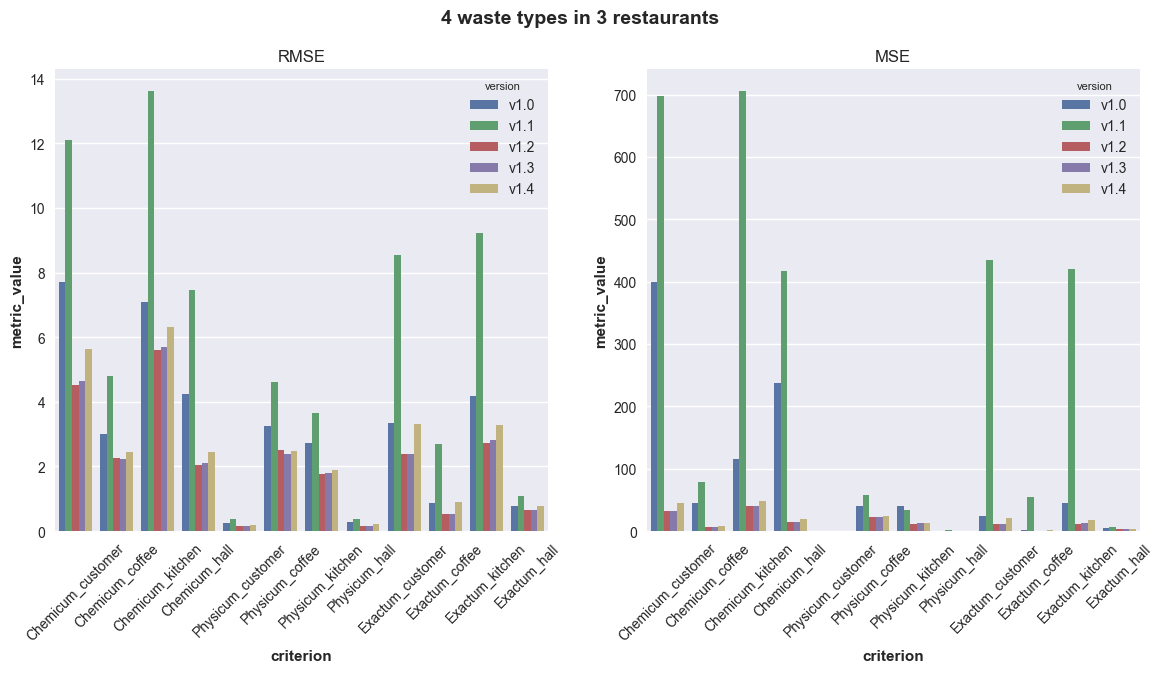

In [23]:
fig = plt.figure(figsize=(14, 6))
fig.suptitle("4 waste types in 3 restaurants", fontweight='bold', fontsize=14)

for i, metric in enumerate(df_metrics['metric'].unique()):
    df_metric = df_metrics[df_metrics['metric'] == metric]

    ax = fig.add_subplot(1, 2, i+1)
    sns.barplot(df_metric, x='criterion', y='metric_value', hue='version', ax=ax)
    ax.set_title(metric.upper())
    ax.tick_params(axis='x', labelrotation = 45)

## Plot single component

<Axes: xlabel='date'>

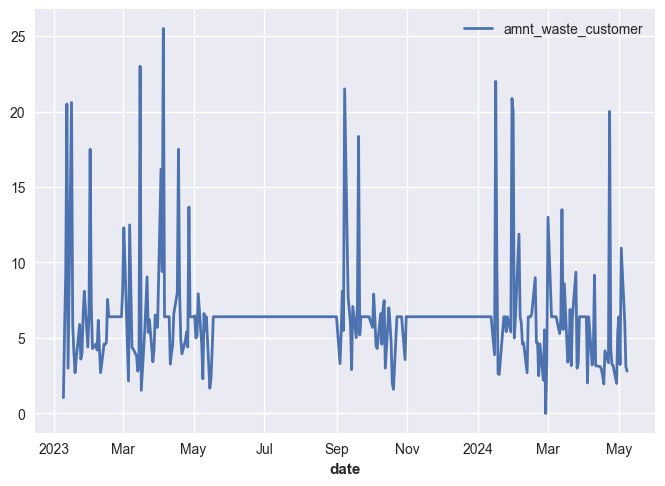

In [10]:
series['amnt_waste_customer'].plot()

## Plot all components

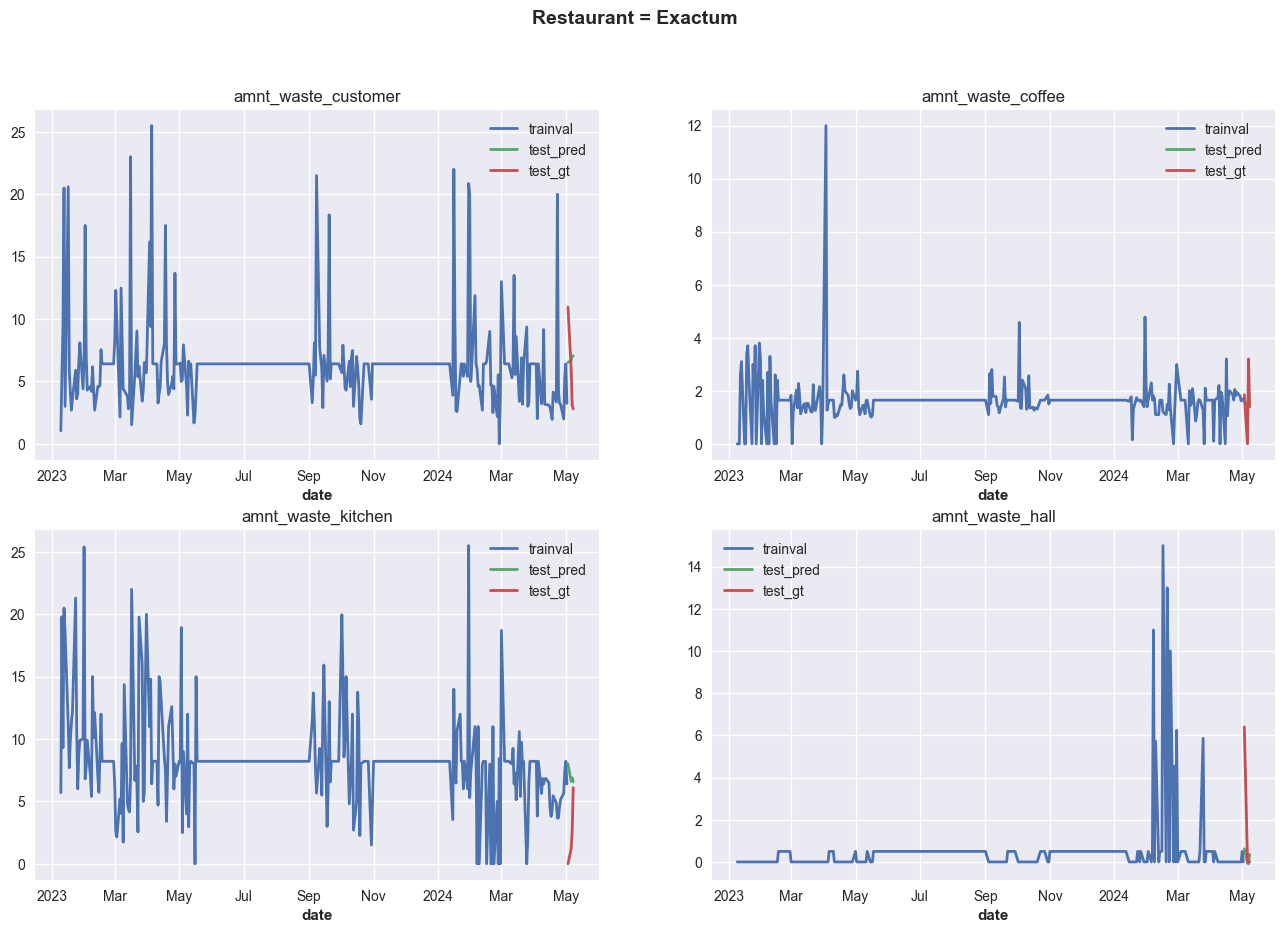

In [16]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle(f"Restaurant = {restaurant}", fontweight='bold', fontsize=14)

for i, component in enumerate(series_train.components):
    ax = fig.add_subplot(2, 2, i+1)
    
    series_train[component].plot(ax=ax, label='trainval')
    series_test_pred[component].plot(ax=ax, label='test_pred')
    series_test[component][:5].plot(ax=ax, label='test_gt')
    ax.set_title(component)

# Other explorations

In [23]:
for restaurant in RESTAURANTS:
    print(f"Restaurant = {restaurant}")

    for component in series[restaurant].components:
        pval = adfuller(series[restaurant][component].data_array().to_numpy().squeeze())[1]

        print(f"{component:<20}: {pval:.4f}")

Restaurant = Chemicum
amnt_waste_customer : 0.0138
amnt_waste_coffee   : 0.2322
amnt_waste_kitchen  : 0.0018
amnt_waste_hall     : 0.5247
Restaurant = Physicum
amnt_waste_customer : 0.0022
amnt_waste_coffee   : 0.0000
amnt_waste_kitchen  : 0.0000
amnt_waste_hall     : 0.0004
Restaurant = Exactum
amnt_waste_customer : 0.0000
amnt_waste_coffee   : 0.0000
amnt_waste_kitchen  : 0.0012
amnt_waste_hall     : 0.0007


In [36]:
out = model.backtest(
    series_train,
    forecast_horizon=FORECAST_HORIZON,
    metric=[metrics.rmse, metrics.mse],
    metric_kwargs={'component_reduction': None}
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


In [38]:
out.T

array([[ 6.42647279, 69.29066081],
       [ 2.51146334,  8.76671832],
       [ 6.71985814, 64.05678064],
       [ 3.24081439, 29.5145576 ]])

In [27]:
restaurant = 'Chemicum'
waste = 'amnt_waste_customer'

s = series[restaurant][waste]
s_train, s_test = s.split_before(CUTOFF_TRAIN_TEST)

In [28]:
add_encoders = {
    'cyclic': {
        'future': ['dayofweek']
    },
    'datetime_attribute': {'future': ['dayofweek']},
}
model = ARIMA()
model.fit(s_train)

model.backtest(
    s_train,
    forecast_horizon=FORECAST_HORIZON,
    metric=[metrics.rmse, metrics.mse]
)

/home/hoanghu/miniforge3/envs/fw/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


array([ 4.56478866, 31.7473931 ])

<Axes: xlabel='date'>

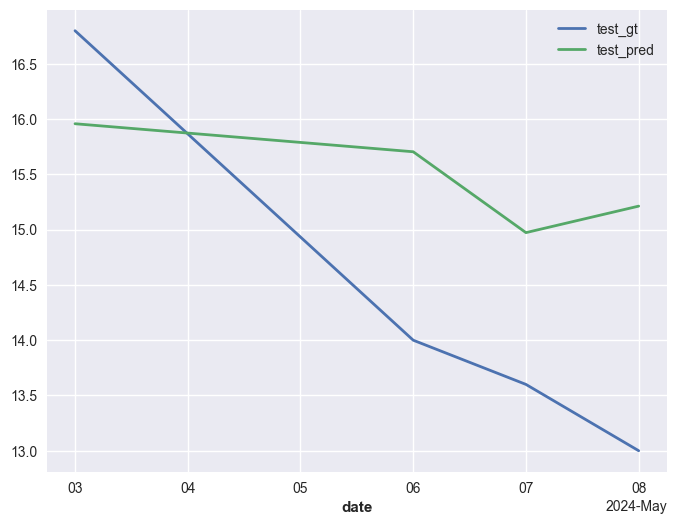

In [30]:
s_test_pred = model.predict(len(s_test))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

s_test.plot(ax=ax, label='test_gt')
s_test_pred.plot(ax=ax, label='test_pred')

# Load models

In [25]:
add_encoders = {
        'cyclic': {
            'past': ['dayofweek']
        },
        'datetime_attribute': {'past': ['dayofweek']},
    }

models = {'biowaste': {}}

for restaurant in RESTAURANTS:
    path_model = Path(f"trained_models/biowaste/{restaurant}.pt")

    models['biowaste'][restaurant] = LinearRegressionModel(
        lags=5,
        lags_past_covariates=5,
        add_encoders=add_encoders,
        output_chunk_length=5
    ).load(path_model)

In [26]:
num_of_days = 3

predictions = {}

# Forecast the future
for restaurant in RESTAURANTS:
    pred = models['biowaste'][restaurant].predict(num_of_days)

    df_pred = pred.pd_dataframe().reset_index()
    df_pred['date'] = df_pred['date'].dt.strftime(r"%Y-%m-%d")

    for row in df_pred.itertuples():
        if row.date not in predictions:
            predictions[row.date] = {'date': row.date}

        predictions[row.date][restaurant] = {
            'amnt_waste_customer': row.amnt_waste_customer,
            'amnt_waste_coffee': row.amnt_waste_coffee,
            'amnt_waste_kitchen': row.amnt_waste_kitchen,
            'amnt_waste_hall': row.amnt_waste_hall,
        }

print(json.dumps(predictions, indent=2))

{
  "2024-05-09": {
    "date": "2024-05-09",
    "Chemicum": {
      "amnt_waste_customer": 15.335807096971186,
      "amnt_waste_coffee": 6.749373675160983,
      "amnt_waste_kitchen": 13.120679698841172,
      "amnt_waste_hall": 12.76089686219699
    },
    "Physicum": {
      "amnt_waste_customer": -0.09098052978515625,
      "amnt_waste_coffee": 11.28973388671875,
      "amnt_waste_kitchen": 12.328250885009766,
      "amnt_waste_hall": 0.17769622802734375
    },
    "Exactum": {
      "amnt_waste_customer": 5.2109375,
      "amnt_waste_coffee": 1.4091796875,
      "amnt_waste_kitchen": 8.2734375,
      "amnt_waste_hall": -1.39208984375
    }
  },
  "2024-05-10": {
    "date": "2024-05-10",
    "Chemicum": {
      "amnt_waste_customer": 14.879137084963158,
      "amnt_waste_coffee": 8.28143831276184,
      "amnt_waste_kitchen": 16.26109595145685,
      "amnt_waste_hall": 14.719872271067954
    },
    "Physicum": {
      "amnt_waste_customer": -0.07980728149414062,
      "amnt_waste